In [ ]:
import argparse
import logging
import sys
import os
import random
import json
from pathlib import Path
import numpy as np
import pandas as pd

import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data.dataset import random_split

from shrp.datasets.dataset_tokens import DatasetTokens
from shrp.git_re_basin.git_re_basin import (
    resnet18_permutation_spec,
    zoo_cnn_large_permutation_spec,
    zoo_cnn_permutation_spec)

from shrp.models.def_downstream_module import DownstreamTaskLearner


ROOT = Path("")

In [108]:
zoo_path = Path("/ds2/model_zoos/zoos_v2/MNIST/tune_zoo_mnist_uniform/")

result_key_list = ["test_acc", "test_loss"]
config_key_list = []
property_keys = {
    "result_keys": result_key_list,
    "config_keys": config_key_list
}
tokensize=0
permutation_spec = zoo_cnn_permutation_spec()

In [109]:
# config to set how datasets should be downloaded. set in single place to ensure 
dataset_config = {
    'epoch_lst' : 50,
    'mode' : "vector",
    'permutation_spec' : permutation_spec,
    'map_to_canonical' : False,
    'standardize' : "l2_ind",
    'ds_split' : [0.7, 0.15, 0.15],  
    'max_samples' : None,
    'weight_threshold' : 15000,
    'precision' : "32",
    'filter_function' : None,  # gets sample path as argument and returns True if model needs to be filtered out
    'num_threads' : 8,
    'shuffle_path' : True,
    'verbosity' : 3,
    'getitem' : "tokens+props",
    'ignore_bn' : False,
    'tokensize' : tokensize
}

In [110]:
trainset = DatasetTokens(root=[zoo_path.absolute()], train_val_test='train',  property_keys=property_keys, **dataset_config)
testset = DatasetTokens(root=[zoo_path.absolute()], train_val_test='test',  property_keys=property_keys, **dataset_config)
valset = DatasetTokens(root=[zoo_path.absolute()], train_val_test='val', property_keys=property_keys, **dataset_config)

2023-08-18 17:41:36,902	WARNING services.py:1780 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 1073709056 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=2.32gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2023-08-18 17:41:37,842	INFO worker.py:1553 -- Started a local Ray instance.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 700/700 [00:14<00:00, 49.39it/s]
700it [00:48, 14.52it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

In [96]:
print(len(trainset))
print(len(testset))
print(len(valset))

1785
383
382


In [51]:
print(testset.properties.keys())

dict_keys(['test_acc', 'test_loss'])


In [87]:
df = pd.read_csv("../../data/all_results.csv")

In [111]:
data = df[(df.dataset=="MNIST") & (df.setup=="seed")]

In [65]:
len(data)/10

2560.0

In [112]:
train_attack = [0 for i in range(len(trainset.properties["test_acc"]))]
train_loss = [0 for i in range(len(trainset.properties["test_loss"]))]
for i, elem in enumerate(trainset.properties["test_acc"]):

    path = str(trainset.get_paths(i)[0]).split("/")[-1]
    
    att = data[data.name == str(trainset.get_paths(i)[0]).split("/")[-1]].iloc[0,17]
    train_attack[i] = [att]
    
    lo = data[data.name == str(trainset.get_paths(i)[0]).split("/")[-1]].iloc[0,16]
    train_loss[i] = [lo]

In [113]:
test_attack = [0 for i in range(len(testset.properties["test_acc"]))]
test_loss = [0 for i in range(len(testset.properties["test_loss"]))]
for i, elem in enumerate(testset.properties["test_acc"]):

    path = str(testset.get_paths(i)[0]).split("/")[-1]
    
    att = data[data.name == str(testset.get_paths(i)[0]).split("/")[-1]].iloc[0,17]
    test_attack[i] = [att]
    
    lo = data[data.name == str(testset.get_paths(i)[0]).split("/")[-1]].iloc[0,16]
    test_loss[i] = [lo]

In [114]:
val_attack = [0 for i in range(len(valset.properties["test_acc"]))]
val_loss = [0 for i in range(len(valset.properties["test_loss"]))]
for i, elem in enumerate(valset.properties["test_acc"]):

    path = str(valset.get_paths(i)[0]).split("/")[-1]
    
    att = data[data.name == str(valset.get_paths(i)[0]).split("/")[-1]].iloc[0,17]
    val_attack[i] = [att]
    
    lo = data[data.name == str(valset.get_paths(i)[0]).split("/")[-1]].iloc[0,16]
    val_loss[i] = [lo]

In [92]:
print(len(val_attack), len(val_loss))
print(len(train_attack), len(train_loss))
print(len(test_attack), len(test_loss))

382 382
1785 1785
383 383


In [115]:
trainset.properties["attack_acc"] = train_attack
testset.properties["attack_acc"] = test_attack
valset.properties["attack_acc"] = val_attack

trainset.properties["attack_loss"] = train_loss
testset.properties["attack_loss"] = test_loss
valset.properties["attack_loss"] = val_loss

In [101]:
trainset.properties.keys()

dict_keys(['test_acc', 'test_loss', 'attack_acc', 'attack_loss'])

<Axes: ylabel='Count'>

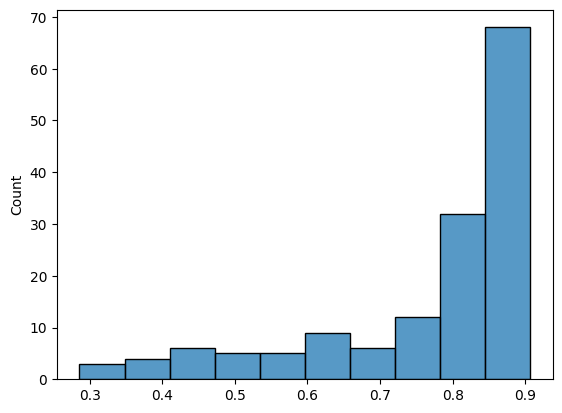

In [77]:
a = [elem[0] for elem in test_attack]
sns.histplot(a)

In [80]:
print(np.mean(a))
print(np.std(a))

0.7672753333333333
0.15586262025115435


In [64]:
testset.properties.keys()

dict_keys(['test_acc', 'test_loss', 'attack_acc', 'attack_loss'])

In [107]:
# hacker code python
from shrp.models.def_AE_module import AEModule
from shrp.models.downstream_baselines import LayerQuintiles

model_path = Pathmodel_path = Path(
    "/netscratch2/kschuerholt/code/shrp/experiments/02_representation_learning/03_kde_sampling/tune/mnist_kde_sampling_ep21-25_v7/AE_trainable_879a1_00000_0_2023-08-15_13-56-27"
    # "/netscratch2/kschuerholt/code/shrp/experiments/02_representation_learning/03_kde_sampling/tune/mnist_kde_sampling_ep21-25_v6/AE_trainable_32c22_00000_0_ae_d_model=512,ae_lat_dim=64,ae_nhead=16_2023-08-06_19-26-53"
)

config = json.load(model_path.joinpath("params.json").open("r"))
config["device"] = "cpu"
#config["device"] = "cuda"
config["training::steps_per_epoch"] = 123
module = AEModule(config)

# checkpoint = torch.load(
#     model_path.joinpath("checkpoint_000100/state.pt"), map_location=config["device"]
# )
# module.model.load_state_dict(checkpoint["model"])
module.model = LayerQuintiles()

INFO: Global seed set to 32
INFO:lightning.fabric.utilities.seed:Global seed set to 32


model: use simclr NT_Xent loss
Running single-gpu. send model to device: cpu
num decayed parameter tensors: 137, with 101,022,596 parameters
num non-decayed parameter tensors: 72, with 34,177 parameters
using fused AdamW: False
++++++ USE AUTOMATIC MIXED PRECISION +++++++


In [116]:
## reference: AE

dstk = DownstreamTaskLearner()

# compute dst perf
performance = dstk.eval_dstasks(
        model=module,
        trainset=trainset,
        testset=testset,
        valset=valset,
        task_keys=['test_acc', 'test_loss', 'attack_acc', 'attack_loss'],
        batch_size=config["trainset::batchsize"],
    )
performance

Prepare embeddings


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.66it/s]


{'test_acc_train': 0.31504897449512737,
 'test_acc_test': 0.1952200310807326,
 'test_acc_val': 0.2560547124166711,
 'test_loss_train': 0.3215773452306102,
 'test_loss_test': 0.20076572765760026,
 'test_loss_val': 0.24422744136052077,
 'attack_acc_train': 0.6283831001095246,
 'attack_acc_test': 0.4870578626865406,
 'attack_acc_val': 0.5799303622006786,
 'attack_loss_train': 0.5957154105814351,
 'attack_loss_test': 0.4280111725630513,
 'attack_loss_val': 0.5705743364124651}

In [69]:
results_df.head()

,setup,train,test,val
0,test_acc,0.300449,0.145864,0.186811
1,test_loss,0.31517,0.107957,0.174139
2,attack_acc,0.334681,0.060005,0.216331
3,attack_loss,0.288793,-0.008258,0.208535


In [72]:
performance.keys()

dict_keys(['test_acc_train', 'test_acc_test', 'test_acc_val', 'test_loss_train', 'test_loss_test', 'test_loss_val', 'attack_acc_train', 'attack_acc_test', 'attack_acc_val', 'attack_loss_train', 'attack_loss_test', 'attack_loss_val'])

In [52]:
column_list = list(performance.keys())
column_list.append("ds")
column_list.append("setup")
test = pd.DataFrame(columns=column_list)

test.loc[0, :] = performance
test.loc[0, "ds"] = "MNIST"
test.loc[0, "setup"] = "seed"

In [55]:
def return_names_for_path(dataset, setup):
    if setup=="hyp-10-r":
        abbr = "random"
    elif setup=="hyp-10-f":
        abbr = "fixed"

    if dataset == "CIFAR10":
        part1 = os.path.join(dataset, "large")

        if setup == "seed":
            part2 = f"tune_zoo_{dataset.lower()}_uniform_large"
        else:
            part2 = f"tune_zoo_{dataset.lower()}_large_hyperparameter_10_{abbr}_seeds"
    
    else:
        part1 = dataset

        if setup == "seed":
            part2 = f"tune_zoo_{dataset.lower()}_uniform"
        else:
            part2 = f"tune_zoo_{dataset.lower()}_hyperparameter_10_{abbr}_seeds"
    
    return part1, part2

In [58]:
zoo_root = Path("/ds2/model_zoos/zoos_v2/")
dataset_path1, dataset_path2 = return_names_for_path("MNIST", "seed")
zoo_path = zoo_root.joinpath(dataset_path1, dataset_path2)

In [59]:
zoo_path

PosixPath('/ds2/model_zoos/zoos_v2/MNIST/tune_zoo_mnist_uniform')

In [17]:
print(performance.keys())

dict_keys(['test_acc_train', 'test_acc_test', 'test_acc_val', 'test_loss_train', 'test_loss_test', 'test_loss_val', 'attack_acc_train', 'attack_acc_test', 'attack_acc_val', 'attack_loss_train', 'attack_loss_test', 'attack_loss_val'])


In [24]:
keys = list(performance.keys())

In [22]:
print(list(performance.keys())[:int(len(performance.keys())/2)])

['test_acc_train', 'test_acc_test', 'test_acc_val', 'test_loss_train', 'test_loss_test', 'test_loss_val']


In [29]:
results_df = pd.DataFrame(columns=["setup", "train", "test", "val"])
for i in range(4):
    results_df.loc[i, "train"] =  performance[keys[i * 3]]
    results_df.loc[i, "test"] =  performance[keys[i * 3 + 1]]
    results_df.loc[i, "val"] =  performance[keys[i * 3 + 2]]
results_df.loc[0, "setup"] = "test_acc"
results_df.loc[1, "setup"] = "test_loss"
results_df.loc[2, "setup"] = "attack_acc"
results_df.loc[3, "setup"] = "attack_loss"

In [81]:
b = pd.read_csv("hyper_results.csv")

In [82]:
b

,Unnamed: 0,test_acc_train,test_acc_test,test_acc_val,test_loss_train,test_loss_test,test_loss_val,attack_acc_train,attack_acc_test,attack_acc_val,attack_loss_train,attack_loss_test,attack_loss_val,ds,setup
0,0,0.300449,0.145864,0.186811,0.315170,0.107957,0.174139,0.334681,0.060005,0.216331,0.288793,-0.008258,0.208535,MNIST,seed
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MNIST,hyp-10-f
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MNIST,hyp-10-r
3,3,0.085265,0.013858,0.017160,0.050061,0.017845,-0.003100,0.134726,-0.012292,0.022114,0.104357,-0.032848,0.024416,CIFAR10,seed
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CIFAR10,hyp-10-f
5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CIFAR10,hyp-10-r
6,6,0.925424,0.823249,0.689896,0.914350,0.795574,0.660031,0.811280,0.634725,0.485360,0.047511,0.025776,0.010988,SVHN,seed
7,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SVHN,hyp-10-f
8,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SVHN,hyp-10-r
